In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import pearsonr
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
sen_pairs = pd.read_csv('./sentence_pairs.csv')
sen_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 6 columns):
sentenceA                                                                      555 non-null object
sentenceB                                                                      555 non-null object
if_sentence_a_is_true_then                                                     555 non-null object
to_what_extent_are_the_two_sentences_expressing_a_related_meaning              555 non-null float64
to_what_extent__are_the_two_sentences_expressing_a_related_meaning:variance    555 non-null float64
Unnamed: 5                                                                     1 non-null float64
dtypes: float64(3), object(3)
memory usage: 26.1+ KB


C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


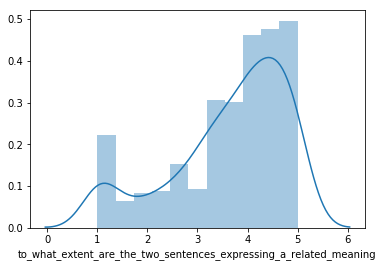

In [17]:
sns.distplot(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning)

## Basic Matching

In [18]:
def get_distance_jaccard(sen1, sen2):
    sen1 = sen1.lower()
    sen2 = sen2.lower()
    sen1 = set(sen1.split(" "))
    sen2 = set(sen2.split(" "))
    return float(len(sen1 & sen2))/(len(sen1 | sen2))

In [19]:
sen_pairs['dist_jaccard'] = sen_pairs.apply(lambda row: get_distance_jaccard(row['sentenceA'],row['sentenceB']), axis=1)
pearsonr(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
            sen_pairs['dist_jaccard'])

(0.61916838528662521, 4.7779090655514145e-60)

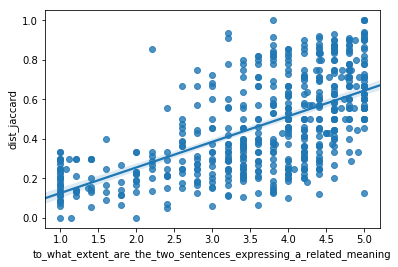

In [31]:
sns.regplot(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, sen_pairs['dist_jaccard'])

## Sentence Embeddings

In [21]:
max(sen_pairs.sentenceA.apply(len)), max(sen_pairs.sentenceB.apply(len))

(110, 125)

In [46]:
glove = dict()
f = open('./glove.6B.300d.txt', encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs

In [47]:
len(glove.get('girl')), glove.get('girl')

(300, array([-0.53162003, -0.09448   , -0.64178997, -0.15832999, -0.30416   ,
         0.0037697 , -0.095559  , -0.052004  , -0.38696   , -0.59663999,
         0.18268999,  0.12519   ,  0.10944   ,  0.27866   , -0.030634  ,
        -0.26456001, -0.18421   , -0.39912   , -0.079178  , -0.35385001,
        -0.27695999,  1.07099998, -0.37702999,  0.042312  , -0.17163999,
        -0.39486   ,  0.20349   , -0.14311001, -0.025186  ,  0.35583001,
        -0.33792999,  0.023528  , -0.099218  ,  0.099467  , -0.62299001,
         0.67047   , -0.41892999,  0.36567   ,  0.15631001,  0.31049001,
         0.46096   , -0.78185999,  0.18715   ,  0.039527  ,  0.013236  ,
        -0.081264  ,  0.49847001, -0.43751001, -0.043778  , -0.014313  ,
         0.16168   , -0.36985001, -0.11449   ,  0.45642   , -0.44692001,
        -0.42552999, -0.12041   , -0.14830001,  0.41632   , -0.66043001,
         0.21877   ,  0.28110999,  0.37496001,  0.022184  , -0.19752   ,
        -0.49166   ,  0.17344999, -0.38144001,

In [48]:
tkn = Tokenizer()
tkn.fit_on_texts(sen_pairs.sentenceA)
tkn.fit_on_texts(sen_pairs.sentenceB)
vocab_size = len(tkn.word_index) + 1
enc_senA = tkn.texts_to_sequences(sen_pairs.sentenceA)
enc_senB = tkn.texts_to_sequences(sen_pairs.sentenceB)
padded_senA = pad_sequences(enc_senA, 125)
padded_senB = pad_sequences(enc_senB, 125)

In [49]:
sen_pairs.sentenceA[1], enc_senA[1], padded_senA[1]

('A man is riding a skateboard in a park',
 [1, 5, 2, 24, 1, 333, 4, 1, 97],
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          5,   2,  24,   1, 333,   4,   1,  97]))

In [56]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tkn.word_index.items():
    glove_vec = glove.get(word)
    if(glove_vec is not None):
        embedding_matrix[i] = glove_vec
# embedding_matrix[1:2]

In [51]:
word_embed_senA = (np.array([(embedding_matrix[l]) for w in padded_senA.tolist() for l in w])).reshape((555, 125, -1))
word_embed_senB = (np.array([(embedding_matrix[l]) for w in padded_senB.tolist() for l in w])).reshape((555, 125, -1))
word_embed_senA.shape, word_embed_senB.shape

((555, 125, 300), (555, 125, 300))

In [52]:
def get_l2norm(mat):
    return mat/np.sqrt((mat**2).sum(axis=1)[:,None])

In [53]:
sent_emb_senA = np.sum(word_embed_senA, axis=1)
sent_emb_senA = get_l2norm(sent_emb_senA)
sent_emb_senB = np.sum(word_embed_senB, axis=1)
sent_emb_senB = get_l2norm(sent_emb_senB)
sent_emb_senA.shape, sent_emb_senB.shape 

((555, 300), (555, 300))

In [54]:
pearsonr(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
         np.sum(sent_emb_senA*sent_emb_senB, axis=1).tolist())

(0.65148992025476038, 2.4024540377830671e-68)

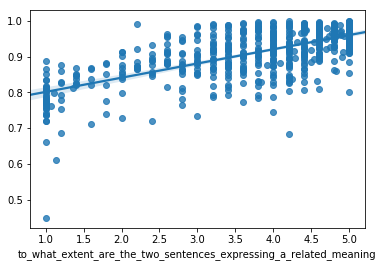

In [55]:
similarity_cosine = np.sum(sent_emb_senA*sent_emb_senB, axis=1)
sns.regplot(sen_pairs.to_what_extent_are_the_two_sentences_expressing_a_related_meaning, 
            similarity_cosine)
# plt.ylim(0)